In [7]:
import io
import os
from functools import reduce
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def unproject_pixels(mask, depth_map, cam_matrix, fx, fy):
    """
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    """
    depth = depth_map[mask]
    pts = np.array([[x, y] for x, y in zip(np.nonzero(mask)[0], np.nonzero(mask)[1])])
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)

    height = depth_map.shape[0]
    width = depth_map.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    intrinsics = np.array([[fx, 0, width / 2.0], [0, fy, height / 2.0], [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate(
        (points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0
    )
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T  # .reshape(3, height, width)

    return points_in_world


def blackout_image(depth_map, area):
    zero_depth_map = np.zeros(depth_map.shape)
    zero_depth_map[area] = depth_map[area]
    return zero_depth_map


def get_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img == color
        arr = arr.min(-1).astype("float32")
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)

In [3]:
buggy_stims = [
    "pilot-containment-cone-plate_0017",
    "pilot-containment-cone-plate_0022",
    "pilot-containment-cone-plate_0029",
    "pilot-containment-cone-plate_0034",
    "pilot-containment-multi-bowl_0042",
    "pilot-containment-multi-bowl_0048",
    "pilot-containment-vase_torus_0031",
    "pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0005",
    "pilot_it2_collision_non-sphere_box_0002",
    "pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0004",
    "pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0007",
    "pilot_it2_drop_simple_box_0000",
    "pilot_it2_drop_simple_box_0042",
    "pilot_it2_drop_simple_tdw_1_dis_1_occ_0003",
    "pilot_it2_rollingSliding_simple_collision_box_0008",
    "pilot_it2_rollingSliding_simple_collision_box_large_force_0009",
    "pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0002",
    "pilot_it2_rollingSliding_simple_ledge_tdw_1_dis_1_occ_0021",
    "pilot_it2_rollingSliding_simple_ledge_tdw_1_dis_1_occ_sphere_small_zone_0022",
    "pilot_it2_rollingSliding_simple_ramp_box_small_zone_0006",
    "pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0004",
    "pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0017",
    "pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0022",
    "pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0012",
    "pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0006",
    "pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0010",
    "pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0029",
    "pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0036",
    "pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0028",
    "pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0000",
    "pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0002",
    "pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0003",
    "pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0010",
    "pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0013",
    "pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0017",
    "pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0018",
    "pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0032",
    "pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0036",
    "pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0021",
    "pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0041",
    "pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0006",
    "pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0009",
]

human_stims = ['pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0039',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0003',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0029',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0021',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0002',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0032',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_unstable_0037',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0023',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0044',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0038',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0015',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0027',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0016',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0029',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0008',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0024',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0035',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0021',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0027',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0024',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0028',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0043',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0037',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0041',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0031',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0026',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0013',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_unstable_0044',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0017',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0006',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0004',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0008',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0035',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0010',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_unstable_0029',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_unstable_0009',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0025',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0012',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0014',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0033',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0019',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0001',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0020',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0037',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0032',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0002',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0037',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0029',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0010',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0030',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0020',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0042',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0005',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0014',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0027',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0040',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0027',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0031',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0033',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0027',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0022',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0014',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0029',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0012',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0005',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0038',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0032',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0021',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0003',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0041',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0005',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0019',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0028',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0018',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0012',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0033',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0023',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0023',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0007',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0042',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0012',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0032',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0043',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0035',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0004',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0015',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0000',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0022',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0037',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0036',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0031',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0042',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0034',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0033',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0026',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0017',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0043',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0013',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0014',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0029',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0026',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0022',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0013',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0015',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0020',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0021',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0029',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0011',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0028',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0006',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0034',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0033',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0030',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0023',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0006',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0011',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0026',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0028',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0017',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0038',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0004',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0032',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0036',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0030',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0013',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0003',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0037',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0002',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0007',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0034',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0011',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0007',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0023',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_unstable_0016',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono1_dis0_occ0_boxroom_stable_0009',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_stable_0011',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0011',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_unstable_0018',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_unstable_0033',
 'pilot_towers_nb4_SJ025_mono1_dis0_occ0_tdwroom_unstable_0029',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0040',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0005',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0010',
 'pilot_towers_nb3_fr015_SJ025_mono1_dis0_occ0_tdwroom_unstable_0039',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_unstable_0006',
 'pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_stable_0020',
 'pilot_towers_nb2_fr015_SJ010_mono0_dis0_occ0_tdwroom_unstable_0019',
 'pilot_towers_nb4_fr015_SJ000_gr000sph_mono1_dis0_occ0_tdwroom_stable_0018',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0034',
 'pilot_towers_nb4_fr015_SJ000_gr01_mono0_dis1_occ1_tdwroom_unstable_0036',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0020',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0036',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0028',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0012',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0034',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0003',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0004',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0011',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0032',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0008',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0010',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0004',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0006',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0009',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0011',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0031',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0035',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0013',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0032',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0018',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0033',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0011',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0039',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0031',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0001',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0015',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0033',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0037',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0039',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0024',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0028',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0028',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0025',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0038',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0014',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0027',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0001',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0036',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0005',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0033',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0013',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0038',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0029',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0007',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0033',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0038',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0016',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0023',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0011',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0022',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0019',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0002',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0026',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0021',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0020',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0022',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0037',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0034',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0032',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0035',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0008',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0023',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0012',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0035',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0027',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0019',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0009',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0013',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0034',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0003',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0034',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0001',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0023',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0013',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0023',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0029',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0006',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0035',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0010',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0024',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0021',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0014',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0028',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0003',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0020',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0026',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0009',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0036',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0039',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0038',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0011',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0027',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0009',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0015',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0027',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0008',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0027',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0013',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0031',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0029',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0031',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0029',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0031',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0005',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0026',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0010',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0005',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0030',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0019',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0012',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0016',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0034',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0000',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0036',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0012',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0000',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0025',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0018',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0018',
 'pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0017',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0030',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0010',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0015',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0015',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0037',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0014',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0033',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0007',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0033',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0038',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0020',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0035',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0028',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0008',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0035',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0003',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0017',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0030',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0000',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0030',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0036',
 'pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0004',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0020',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0016',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0009',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0029',
 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0006',
 'pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0034',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0011',
 'pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0002',
 'pilot_dominoes_4mid_boxroom_2_0018',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0004',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0010',
 'pilot_dominoes_2mid_J025R30_tdwroom_0016',
 'pilot_dominoes_4mid_boxroom_0011',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0000',
 'pilot_dominoes_4mid_boxroom_2_0008',
 'pilot_dominoes_4midRM1_tdwroom_2_0021',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0023',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0006',
 'pilot_dominoes_4midRM1_tdwroom_0009',
 'pilot_dominoes_2mid_J025R30_tdwroom_0025',
 'pilot_dominoes_default_boxroom_0003',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0007',
 'pilot_dominoes_4mid_tdwroom_0004',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0000',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0025',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0018',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0017',
 'pilot_dominoes_2mid_J025R30_tdwroom_0018',
 'pilot_dominoes_4midRM1_tdwroom_2_0001',
 'pilot_dominoes_4midRM1_tdwroom_0022',
 'pilot_dominoes_1mid_J025R45_boxroom_0010',
 'pilot_dominoes_4mid_boxroom_2_0020',
 'pilot_dominoes_2mid_J025R30_tdwroom_0005',
 'pilot_dominoes_4midRM1_boxroom_2_0024',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0018',
 'pilot_dominoes_4mid_boxroom_0015',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0016',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0024',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0009',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0021',
 'pilot_dominoes_4mid_tdwroom_0018',
 'pilot_dominoes_4midRM1_boxroom_0019',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0022',
 'pilot_dominoes_4midRM1_tdwroom_2_0019',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0026',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0017',
 'pilot_dominoes_4mid_boxroom_2_0022',
 'pilot_dominoes_2mid_J025R30_tdwroom_0000',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0019',
 'pilot_dominoes_1mid_J025R45_boxroom_0024',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0023',
 'pilot_dominoes_1mid_J025R45_boxroom_0019',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0003',
 'pilot_dominoes_4mid_tdwroom_0019',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0013',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0021',
 'pilot_dominoes_default_boxroom_0015',
 'pilot_dominoes_2mid_J025R30_tdwroom_0008',
 'pilot_dominoes_4midRM1_boxroom_2_0017',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0005',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0020',
 'pilot_dominoes_1mid_J025R45_boxroom_0007',
 'pilot_dominoes_1mid_J025R45_boxroom_0002',
 'pilot_dominoes_4mid_boxroom_0018',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0016',
 'pilot_dominoes_1mid_J025R45_boxroom_0000',
 'pilot_dominoes_1mid_J025R45_boxroom_0006',
 'pilot_dominoes_4mid_boxroom_0021',
 'pilot_dominoes_2mid_J025R30_tdwroom_0015',
 'pilot_dominoes_default_boxroom_0004',
 'pilot_dominoes_default_boxroom_0001',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0019',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0020',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0022',
 'pilot_dominoes_4midRM1_tdwroom_2_0024',
 'pilot_dominoes_4mid_tdwroom_0021',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0008',
 'pilot_dominoes_default_boxroom_0014',
 'pilot_dominoes_4midRM1_boxroom_0018',
 'pilot_dominoes_4midRM1_tdwroom_2_0017',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0015',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0013',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0014',
 'pilot_dominoes_2mid_J025R30_tdwroom_0020',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0000',
 'pilot_dominoes_4midRM1_boxroom_2_0006',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0017',
 'pilot_dominoes_default_boxroom_0006',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0010',
 'pilot_dominoes_4midRM1_boxroom_0000',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0026',
 'pilot_dominoes_4midRM1_boxroom_2_0016',
 'pilot_dominoes_2mid_J025R30_tdwroom_0026',
 'pilot_dominoes_default_boxroom_0025',
 'pilot_dominoes_4midRM1_boxroom_0008',
 'pilot_dominoes_4mid_boxroom_2_0002',
 'pilot_dominoes_4midRM1_boxroom_2_0013',
 'pilot_dominoes_4midRM1_boxroom_2_0014',
 'pilot_dominoes_4mid_tdwroom_0008',
 'pilot_dominoes_4midRM1_tdwroom_0005',
 'pilot_dominoes_4midRM1_boxroom_0026',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0009',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0021',
 'pilot_dominoes_1mid_J025R45_boxroom_0012',
 'pilot_dominoes_4midRM1_boxroom_2_0026',
 'pilot_dominoes_4mid_boxroom_0013',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0010',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0005',
 'pilot_dominoes_4midRM1_boxroom_0022',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0012',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0022',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0007',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0023',
 'pilot_dominoes_4mid_tdwroom_0015',
 'pilot_dominoes_4midRM1_boxroom_2_0010',
 'pilot_dominoes_4midRM1_tdwroom_2_0025',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0011',
 'pilot_dominoes_4midRM1_tdwroom_2_0015',
 'pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0025',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0006',
 'pilot_dominoes_2mid_J025R30_tdwroom_0001',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0015',
 'pilot_dominoes_default_boxroom_0017',
 'pilot_dominoes_4mid_tdwroom_0007',
 'pilot_dominoes_2mid_J025R30_tdwroom_0021',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0003',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0016',
 'pilot_dominoes_4midRM1_boxroom_2_0019',
 'pilot_dominoes_4midRM1_boxroom_2_0000',
 'pilot_dominoes_1mid_J025R45_boxroom_0011',
 'pilot_dominoes_default_boxroom_0023',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0019',
 'pilot_dominoes_4mid_tdwroom_0003',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0024',
 'pilot_dominoes_4midRM1_tdwroom_2_0018',
 'pilot_dominoes_default_boxroom_0020',
 'pilot_dominoes_default_boxroom_0016',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0004',
 'pilot_dominoes_4midRM1_tdwroom_2_0026',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_0000',
 'pilot_dominoes_1mid_J025R45_boxroom_0009',
 'pilot_dominoes_1mid_J025R45_boxroom_0014',
 'pilot_dominoes_1mid_J025R45_boxroom_0021',
 'pilot_dominoes_default_boxroom_0026',
 'pilot_dominoes_1mid_J025R45_o1full_tdwroom_0004',
 'pilot_dominoes_1mid_J025R45_boxroom_0022',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0001',
 'pilot_dominoes_4midRM1_boxroom_0001',
 'pilot_dominoes_1mid_J025R45_boxroom_0003',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0002',
 'pilot_dominoes_2mid_J025R30_tdwroom_0024',
 'pilot_dominoes_2mid_J025R30_tdwroom_0003',
 'pilot_dominoes_4midRM1_tdwroom_0011',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0009',
 'pilot_dominoes_4mid_boxroom_2_0014',
 'pilot_dominoes_SJ020_d3chairs_o1plants_tdwroom_0008',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0026',
 'pilot_dominoes_2mid_J020R15_d3chairs_o1plants_tdwroom_2_0004',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0032',
 'pilot_it2_collision_tiny_ball_box_0002',
 'pilot_it2_collision_non-sphere_box_0025',
 'pilot_it2_collision_non-sphere_box_0019',
 'pilot_it2_collision_non-sphere_box_0013',
 'pilot_it2_collision_assorted_targets_tdw_1_dis_1_occ_0035',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0024',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0023',
 'pilot_it2_collision_assorted_targets_tdw_1_dis_1_occ_0034',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0011',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0038',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0028',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0005',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0026',
 'pilot_it2_collision_non-sphere_box_0017',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0033',
 'pilot_it2_collision_simple_box_0005',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0025',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0008',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0034',
 'pilot_it2_collision_non-sphere_box_0033',
 'pilot_it2_collision_simple_box_0006',
 'pilot_it2_collision_simple_box_0012',
 'pilot_it2_collision_non-sphere_box_0018',
 'pilot_it2_collision_non-sphere_box_0032',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0030',
 'pilot_it2_collision_tiny_ball_box_0023',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0007',
 'pilot_it2_collision_yeet_box_0005',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0020',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0022',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0004',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0025',
 'pilot_it2_collision_non-sphere_box_0002',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0035',
 'pilot_it2_collision_non-sphere_box_0036',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0023',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0018',
 'pilot_it2_collision_tiny_ball_tdw_1_dis_1_occ_0021',
 'pilot_it2_collision_simple_box_0015',
 'pilot_it2_collision_assorted_targets_box_0011',
 'pilot_it2_collision_assorted_targets_tdw_1_dis_1_occ_0027',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0021',
 'pilot_it2_collision_tiny_ball_tdw_1_dis_1_occ_0037',
 'pilot_it2_collision_tiny_ball_box_0029',
 'pilot_it2_collision_yeet_box_0007',
 'pilot_it2_collision_tiny_ball_box_0024',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0014',
 'pilot_it2_collision_simple_box_0031',
 'pilot_it2_collision_assorted_targets_tdw_1_dis_1_occ_0007',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0014',
 'pilot_it2_collision_non-sphere_box_0037',
 'pilot_it2_collision_non-sphere_box_0039',
 'pilot_it2_collision_non-sphere_box_0009',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0035',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0013',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0017',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0034',
 'pilot_it2_collision_tiny_ball_box_0014',
 'pilot_it2_collision_tiny_ball_box_0017',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0032',
 'pilot_it2_collision_non-sphere_box_0038',
 'pilot_it2_collision_assorted_targets_box_0017',
 'pilot_it2_collision_simple_box_0025',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0008',
 'pilot_it2_collision_non-sphere_box_0021',
 'pilot_it2_collision_tiny_ball_box_0034',
 'pilot_it2_collision_non-sphere_box_0012',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0009',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0010',
 'pilot_it2_collision_non-sphere_box_0034',
 'pilot_it2_collision_yeet_box_0029',
 'pilot_it2_collision_non-sphere_box_0035',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0038',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0017',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0036',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0020',
 'pilot_it2_collision_non-sphere_box_0007',
 'pilot_it2_collision_yeet_box_0021',
 'pilot_it2_collision_non-sphere_box_0029',
 'pilot_it2_collision_yeet_box_0026',
 'pilot_it2_collision_tiny_ball_box_0013',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0015',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0039',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0011',
 'pilot_it2_collision_non-sphere_box_0010',
 'pilot_it2_collision_yeet_tdw_1_dis_1_occ_0015',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0000',
 'pilot_it2_collision_non-sphere_box_0016',
 'pilot_it2_collision_non-sphere_box_0030',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0019',
 'pilot_it2_collision_non-sphere_box_0023',
 'pilot_it2_collision_simple_box_1_dis_1_occ_0005',
 'pilot_it2_collision_non-sphere_box_0003',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0039',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0007',
 'pilot_it2_collision_tiny_ball_box_0003',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0038',
 'pilot_it2_collision_yeet_box_0030',
 'pilot_it2_collision_non-sphere_box_0015',
 'pilot_it2_collision_simple_box_0017',
 'pilot_it2_collision_tiny_ball_box_0037',
 'pilot_it2_collision_non-sphere_tdw_1_dis_1_occ_0024',
 'pilot_it2_collision_non-sphere_box_0004',
 'pilot_it2_collision_assorted_targets_tdw_1_dis_1_occ_0014',
 'pilot_it2_collision_tiny_ball_tdw_1_dis_1_occ_0000',
 'pilot-containment-bowl_0015',
 'pilot-containment-torus_0011',
 'pilot-containment-torus_0009',
 'pilot-containment-bowl-familiarization_0004',
 'pilot-containment-bowl_0023',
 'pilot-containment-bowl-familiarization_0036',
 'pilot-containment-vase_0031',
 'pilot-containment-vase_torus_0033',
 'pilot-containment-bowl-familiarization_0008',
 'pilot-containment-cylinder-bowl_0030',
 'pilot-containment-vase_0032',
 'pilot-containment-multi-bowl_0015',
 'pilot-containment-vase_torus_0047',
 'pilot-containment-cylinder-bowl_0035',
 'pilot-containment-bowl_0021',
 'pilot-containment-cone-plate_0020',
 'pilot-containment-cone-plate_0034',
 'pilot-containment-vase_0017',
 'pilot-containment-bowl-familiarization_0035',
 'pilot-containment-multi-bowl_0010',
 'pilot-containment-vase_torus_0028',
 'pilot-containment-multi-bowl_0042',
 'pilot-containment-vase_0035',
 'pilot-containment-vase_torus_0042',
 'pilot-containment-multi-bowl_0023',
 'pilot-containment-torus_0044',
 'pilot-containment-bowl-familiarization_0010',
 'pilot-containment-bowl-familiarization_0026',
 'pilot-containment-torus_0020',
 'pilot-containment-multi-bowl_0035',
 'pilot-containment-cone-plate_0022',
 'pilot-containment-bowl_0026',
 'pilot-containment-bowl_0031',
 'pilot-containment-bowl-familiarization_0037',
 'pilot-containment-torus_0022',
 'pilot-containment-bowl_0020',
 'pilot-containment-torus_0017',
 'pilot-containment-vase_torus_0009',
 'pilot-containment-torus_0014',
 'pilot-containment-multi-bowl_0040',
 'pilot-containment-multi-bowl_0046',
 'pilot-containment-bowl-familiarization_0024',
 'pilot-containment-vase_0028',
 'pilot-containment-multi-bowl_0032',
 'pilot-containment-vase_0015',
 'pilot-containment-bowl_0022',
 'pilot-containment-cylinder-bowl_0011',
 'pilot-containment-cylinder-bowl_0021',
 'pilot-containment-multi-bowl_0036',
 'pilot-containment-vase_0023',
 'pilot-containment-vase_0033',
 'pilot-containment-vase_torus_0045',
 'pilot-containment-torus_0040',
 'pilot-containment-cone-plate_0007',
 'pilot-containment-cylinder-bowl_0028',
 'pilot-containment-vase_0036',
 'pilot-containment-cylinder-bowl_0046',
 'pilot-containment-vase_0046',
 'pilot-containment-bowl-familiarization_0044',
 'pilot-containment-bowl_0045',
 'pilot-containment-cylinder-bowl_0026',
 'pilot-containment-vase_torus_0043',
 'pilot-containment-vase_0043',
 'pilot-containment-torus_0037',
 'pilot-containment-multi-bowl_0005',
 'pilot-containment-torus_0042',
 'pilot-containment-vase_0005',
 'pilot-containment-cylinder-bowl_0009',
 'pilot-containment-bowl-familiarization_0009',
 'pilot-containment-bowl-familiarization_0033',
 'pilot-containment-vase_0006',
 'pilot-containment-vase_0039',
 'pilot-containment-bowl_0012',
 'pilot-containment-bowl_0035',
 'pilot-containment-torus_0013',
 'pilot-containment-multi-bowl_0011',
 'pilot-containment-multi-bowl_0029',
 'pilot-containment-vase_torus_0023',
 'pilot-containment-vase_torus_0024',
 'pilot-containment-bowl_0009',
 'pilot-containment-cylinder-bowl_0010',
 'pilot-containment-cylinder-bowl_0027',
 'pilot-containment-bowl_0029',
 'pilot-containment-multi-bowl_0017',
 'pilot-containment-bowl_0040',
 'pilot-containment-bowl-familiarization_0018',
 'pilot-containment-torus_0004',
 'pilot-containment-vase_torus_0037',
 'pilot-containment-torus_0043',
 'pilot-containment-vase_torus_0029',
 'pilot-containment-bowl-familiarization_0027',
 'pilot-containment-cylinder-bowl_0033',
 'pilot-containment-cylinder-bowl_0042',
 'pilot-containment-bowl-familiarization_0013',
 'pilot-containment-multi-bowl_0031',
 'pilot-containment-vase_0000',
 'pilot-containment-cylinder-bowl_0018',
 'pilot-containment-bowl_0005',
 'pilot-containment-torus_0026',
 'pilot-containment-multi-bowl_0018',
 'pilot-containment-torus_0010',
 'pilot-containment-multi-bowl_0048',
 'pilot-containment-bowl_0017',
 'pilot-containment-bowl-familiarization_0019',
 'pilot-containment-cone-plate_0017',
 'pilot-containment-bowl_0024',
 'pilot-containment-vase_0027',
 'pilot-containment-bowl-familiarization_0006',
 'pilot-containment-vase_torus_0002',
 'pilot-containment-multi-bowl_0008',
 'pilot-containment-vase_torus_0000',
 'pilot-containment-multi-bowl_0025',
 'pilot-containment-vase_torus_0032',
 'pilot-containment-bowl-familiarization_0025',
 'pilot-containment-vase_torus_0046',
 'pilot-containment-torus_0000',
 'pilot-containment-multi-bowl_0016',
 'pilot-containment-bowl_0046',
 'pilot-containment-bowl_0044',
 'pilot-containment-bowl_0049',
 'pilot-containment-torus_0048',
 'pilot-containment-vase_torus_0005',
 'pilot-containment-multi-bowl_0041',
 'pilot-containment-bowl-familiarization_0021',
 'pilot-containment-multi-bowl_0049',
 'pilot-containment-cylinder-bowl_0032',
 'pilot-containment-bowl_0048',
 'pilot-containment-bowl-familiarization_0020',
 'pilot-containment-cylinder-bowl_0043',
 'pilot-containment-multi-bowl_0019',
 'pilot-containment-cylinder-bowl_0023',
 'pilot-containment-cone-plate_0045',
 'pilot-containment-torus_0046',
 'pilot-containment-vase_0008',
 'pilot-containment-vase_torus_0031',
 'pilot-containment-multi-bowl_0006',
 'pilot-containment-bowl_0025',
 'pilot-containment-cylinder-bowl_0022',
 'pilot-containment-multi-bowl_0045',
 'pilot-containment-bowl_0042',
 'pilot-containment-cone-plate_0031',
 'pilot-containment-cone-plate_0029',
 'pilot-containment-cylinder-bowl_0045',
 'pilot-containment-vase_0020',
 'pilot-containment-torus_0030',
 'pilot-containment-cylinder-bowl_0006',
 'pilot-containment-torus_0035',
 'pilot-containment-multi-bowl_0037',
 'pilot-containment-cylinder-bowl_0029',
 'pilot-containment-bowl-familiarization_0029',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0000',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0013',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0011',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0010',
 'pilot_it2_rollingSliding_simple_ramp_box_small_zone_0007',
 'pilot_it2_rollingSliding_simple_collision_box_large_force_0030',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0002',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0008',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0013',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0024',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0025',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0029',
 'pilot_it2_rollingSliding_simple_collision_box_large_force_0001',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0011',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0007',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0010',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0016',
 'pilot_it2_rollingSliding_simple_collision_box_0016',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0028',
 'pilot_it2_rollingSliding_simple_ramp_box_0002',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0028',
 'pilot_it2_rollingSliding_simple_ramp_box_0022',
 'pilot_it2_rollingSliding_simple_collision_box_0012',
 'pilot_it2_rollingSliding_simple_collision_box_large_force_0009',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0011',
 'pilot_it2_rollingSliding_simple_ramp_box_0016',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0013',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0028',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0014',
 'pilot_it2_rollingSliding_simple_ramp_box_small_zone_0017',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0004',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0028',
 'pilot_it2_rollingSliding_simple_ramp_box_small_zone_0022',
 'pilot_it2_rollingSliding_simple_ramp_box_small_zone_0003',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0016',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0029',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0029',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0014',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0006',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0002',
 'pilot_it2_rollingSliding_simple_collision_box_0008',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0020',
 'pilot_it2_rollingSliding_simple_ramp_box_small_zone_0026',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0023',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0001',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0011',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0014',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0022',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0017',
 'pilot_it2_rollingSliding_simple_collision_box_0022',
 'pilot_it2_rollingSliding_simple_ramp_box_small_zone_0014',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0015',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0018',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0026',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0005',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0000',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0008',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0022',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0005',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0000',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0012',
 'pilot_it2_rollingSliding_simple_ramp_box_0024',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0030',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0029',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0023',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0016',
 'pilot_it2_rollingSliding_simple_ramp_box_small_zone_0006',
 'pilot_it2_rollingSliding_simple_ramp_box_0015',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0017',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0020',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0019',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0013',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0018',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0027',
 'pilot_it2_rollingSliding_simple_collision_box_large_force_0016',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0030',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0006',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0026',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0030',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0023',
 'pilot_it2_rollingSliding_simple_collision_box_large_force_0005',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0021',
 'pilot_it2_rollingSliding_simple_collision_box_large_force_0028',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0020',
 'pilot_it2_rollingSliding_simple_ramp_box_0014',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0010',
 'pilot_it2_rollingSliding_simple_collision_box_0025',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_0001',
 'pilot_it2_rollingSliding_simple_ramp_box_0029',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0027',
 'pilot_it2_rollingSliding_simple_collision_box_large_force_0021',
 'pilot_it2_rollingSliding_simple_collision_tdw_1_dis_1_occ_0019',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_0028',
 'pilot_it2_rollingSliding_simple_ramp_box_zone_away_small_zone_0008',
 'pilot_it2_rollingSliding_simple_ramp_box_small_zone_0013',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0030',
 'pilot_it2_rollingSliding_simple_ramp_box_small_zone_0000',
 'pilot_it2_rollingSliding_simple_ramp_tdw_1_dis_1_occ_small_zone_0003',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0016',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0022',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0032',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0029',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0004',
 'pilot_it2_drop_simple_box_0019',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0030',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0047',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0030',
 'pilot_it2_drop_sidezone_box_0011',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0040',
 'pilot_it2_drop_simple_box_0003',
 'pilot_it2_drop_all_bowls_box_0011',
 'pilot_it2_drop_sizes_box_0030',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0041',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0025',
 'pilot_it2_drop_all_bowls_box_0028',
 'pilot_it2_drop_all_bowls_box_0017',
 'pilot_it2_drop_sidezone_box_0020',
 'pilot_it2_drop_sizes_box_0009',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0028',
 'pilot_it2_drop_simple_box_0027',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0025',
 'pilot_it2_drop_sidezone_box_0003',
 'pilot_it2_drop_sizes_box_0029',
 'pilot_it2_drop_all_bowls_box_0020',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0007',
 'pilot_it2_drop_sidezone_box_0046',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0044',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0004',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0021',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0002',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0044',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0009',
 'pilot_it2_drop_simple_box_0016',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0033',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0036',
 'pilot_it2_drop_sizes_box_0026',
 'pilot_it2_drop_all_bowls_box_0012',
 'pilot_it2_drop_simple_box_0000',
 'pilot_it2_drop_simple_box_0007',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0021',
 'pilot_it2_drop_all_bowls_box_0023',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0045',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0022',
 'pilot_it2_drop_all_bowls_box_0035',
 'pilot_it2_drop_sizes_box_0011',
 'pilot_it2_drop_simple_box_0042',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0010',
 'pilot_it2_drop_all_bowls_box_0016',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0007',
 'pilot_it2_drop_sizes_box_0036',
 'pilot_it2_drop_simple_box_0020',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0038',
 'pilot_it2_drop_all_bowls_box_0002',
 'pilot_it2_drop_simple_box_0015',
 'pilot_it2_drop_all_bowls_box_0025',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0000',
 'pilot_it2_drop_all_bowls_box_0019',
 'pilot_it2_drop_simple_box_0047',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0013',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0007',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0027',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0048',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0032',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0006',
 'pilot_it2_drop_simple_box_0026',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0002',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0036',
 'pilot_it2_drop_sidezone_box_0034',
 'pilot_it2_drop_simple_box_0018',
 'pilot_it2_drop_sidezone_box_0035',
 'pilot_it2_drop_sidezone_box_0044',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0042',
 'pilot_it2_drop_sizes_box_0049',
 'pilot_it2_drop_sizes_box_0019',
 'pilot_it2_drop_sizes_box_0045',
 'pilot_it2_drop_sidezone_box_0043',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0032',
 'pilot_it2_drop_all_bowls_box_0018',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0005',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0037',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0009',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0040',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0025',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0000',
 'pilot_it2_drop_sidezone_box_0018',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0046',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0018',
 'pilot_it2_drop_all_bowls_box_0024',
 'pilot_it2_drop_sidezone_box_0021',
 'pilot_it2_drop_all_bowls_box_0034',
 'pilot_it2_drop_all_bowls_box_0032',
 'pilot_it2_drop_sizes_box_0010',
 'pilot_it2_drop_sidezone_box_0022',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0013',
 'pilot_it2_drop_all_bowls_box_0042',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0003',
 'pilot_it2_drop_simple_box_0005',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0005',
 'pilot_it2_drop_all_bowls_box_0026',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0014',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0047',
 'pilot_it2_drop_simple_box_0008',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0048',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0001',
 'pilot_it2_drop_simple_box_0040',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0010',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0006',
 'pilot_it2_drop_all_bowls_box_0029',
 'pilot_it2_drop_simple_box_0028',
 'pilot_it2_drop_sidezone_box_0047',
 'pilot_it2_drop_simple_box_0035',
 'pilot_it2_drop_sidezone_box_0048',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0049',
 'pilot_it2_drop_all_bowls_box_0046',
 'pilot_it2_drop_sidezone_box_0015',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0018',
 'pilot_it2_drop_simple_box_0029',
 'pilot_it2_drop_sidezone_box_0032',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0017',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0003',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0029',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0018',
 'pilot_it2_drop_simple_box_0032',
 'pilot_it2_drop_sizes_box_0042',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0016',
 'pilot_it2_drop_sizes_box_0014',
 'pilot_it2_drop_sizes_box_0021',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0008',
 'pilot_it2_drop_simple_box_0010',
 'pilot_it2_drop_simple_box_0033',
 'pilot_it2_drop_sidezone_box_0042',
 'pilot_it2_drop_sidezone_box_0019',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0012',
 'pilot_it2_drop_sizes_box_0041',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0039',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0026',
 'pilot_it2_drop_sizes_box_0017',
 'pilot_it2_drop_sidezone_box_0024',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0038',
 'pilot_it2_drop_simple_box_0017',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0026',
 'pilot_it2_drop_sizes_tdw_1_dis_1_occ_0023',
 'pilot_it2_drop_all_bowls_box_0037',
 'pilot_it2_drop_all_bowls_tdw_1_dis_1_occ_0029',
 'pilot_it2_drop_sizes_box_0008',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0041',
 'pilot_it2_drop_sidezone_tdw_1_dis_1_occ_0008',
 'pilot_it2_drop_simple_tdw_1_dis_1_occ_0049']

onlyhdf5 = []
hdf5_file_path = "/home/haoliangwang/data/physion_hdf5"
path = '/home/haoliangwang/data/b3d_tracking_results/test'
for root, dirs, files in os.walk(hdf5_file_path):
    for file in files:
        if file.endswith('.hdf5'):
            stim_name = file[:-5]
            if stim_name in human_stims and stim_name not in buggy_stims:
                onlyhdf5.append(os.path.join(root, file))
# scenario = 'collide'

In [11]:
im_width = 350
im_height = 350
width = 1024
height = 1024
near_plane = 0.1
far_plane = 100

num_pose_grid = 12

scaling_factor = im_height / height
vfov = 54.43222 / 180.0 * np.pi
tan_half_vfov = np.tan(vfov / 2.0)
tan_half_hfov = tan_half_vfov * width / float(height)
fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
fy = height / 2.0 / tan_half_vfov

all_info = {}
for stim_path in onlyhdf5:
    this_info = []
    stim_name = stim_path.split('/')[-1][:-5]
    print("\t", stim_name)
    with h5py.File(stim_path, "r") as f:
        # extract depth info
        depth = np.array(f["frames"]["0000"]["images"]["_depth_cam0"])
        image = (
            np.array(
                Image.open(
                    io.BytesIO(f["frames"]["0000"]["images"]["_img_cam0"][:])
                )
            )
            / 255
        )
        im_seg = np.array(
            Image.open(io.BytesIO(f["frames"]["0000"]["images"]["_id_cam0"][:]))
        )

        # extract camera info
        camera_matrix = np.array(
            f["frames"]["0000"]["camera_matrices"]["camera_matrix_cam0"]
        ).reshape((4, 4))

        # extract object info
        object_ids = np.array(f["static"]["object_ids"])
        model_names = np.array(f["static"]["model_names"])
        object_scales = np.array(f["static"]["scale"])
        object_segmentation_colors = np.array(
            f["static"]["object_segmentation_colors"]
        )
        initial_position = np.array(f["static"]["initial_position"])

        assert (
            len(object_ids) == len(object_scales) == len(model_names) == len(object_segmentation_colors) == len(initial_position)
        )

        distractors = (
            np.array(f["static"]["distractors"])
            if np.array(f["static"]["distractors"]).size != 0
            else []
        )
        occluders = (
            np.array(f["static"]["occluders"])
            if np.array(f["static"]["occluders"]).size != 0
            else []
        )
        distractors_occluders = np.concatenate([distractors, occluders])
        if len(distractors_occluders):
            object_ids = object_ids[: -len(distractors_occluders)]
            model_names = model_names[: -len(distractors_occluders)]
            object_scales = object_scales[: -len(distractors_occluders)]
            object_segmentation_colors = object_segmentation_colors[
                : -len(distractors_occluders)
            ]
            initial_position = initial_position[: -len(distractors_occluders)]
            
    rgbd = np.concatenate([image, np.reshape(depth, depth.shape + (1,))], axis=-1)

    this_trial_info = {}
    for i, color in enumerate(object_segmentation_colors):
        object_scale = object_scales[i]
        area = get_mask_area(im_seg, [color])
        image_masked = blackout_image(rgbd, area)

        point_cloud = np.asarray(
            unproject_pixels(area, image_masked[..., -1], camera_matrix, fx, fy)
        )
        point_cloud_centroid = point_cloud.mean(0)
        this_trial_info[object_ids[i]] = {
            "x": np.abs(initial_position[i][0]-point_cloud_centroid[0]),
            "y": np.abs(initial_position[i][1]-point_cloud_centroid[1]),
            "b": np.abs(initial_position[i][1]-min(point_cloud[:, 1])),
            "z": np.abs(initial_position[i][2]-point_cloud_centroid[2]),
        }
    all_info[stim_name] = this_trial_info

	 pilot-containment-cone-plate_0031
	 pilot-containment-bowl-familiarization_0018
	 pilot-containment-bowl_0026
	 pilot-containment-cylinder-bowl_0021
	 pilot-containment-vase_torus_0033
	 pilot-containment-multi-bowl_0029
	 pilot-containment-bowl-familiarization_0033
	 pilot-containment-vase_torus_0009
	 pilot-containment-multi-bowl_0025
	 pilot-containment-vase_torus_0043
	 pilot-containment-bowl-familiarization_0026
	 pilot-containment-vase_torus_0032
	 pilot-containment-torus_0022
	 pilot-containment-bowl-familiarization_0024
	 pilot-containment-bowl-familiarization_0035
	 pilot-containment-cylinder-bowl_0010
	 pilot-containment-vase_0000
	 pilot-containment-cylinder-bowl_0028
	 pilot-containment-cylinder-bowl_0026
	 pilot-containment-torus_0017
	 pilot-containment-cylinder-bowl_0023
	 pilot-containment-vase_0031
	 pilot-containment-bowl_0044
	 pilot-containment-cylinder-bowl_0006
	 pilot-containment-bowl_0024
	 pilot-containment-vase_torus_0037
	 pilot-containment-multi-bowl_0037


In [12]:
xs = []
ys = []
zs = []
bs = []
for val in all_info.values():
    for v in list(val.values()):
        xs.append(v['x'])
        ys.append(v['y'])
        zs.append(v['z'])
        bs.append(v['b'])

Text(0.5, 1.0, '0.6514130740849218')

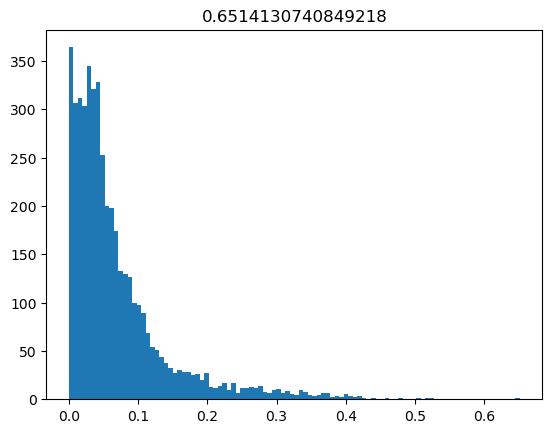

In [13]:
plt.hist(xs, bins=100)
plt.title(f'{np.max(xs)}')

Text(0.5, 1.0, '0.7648777671109368')

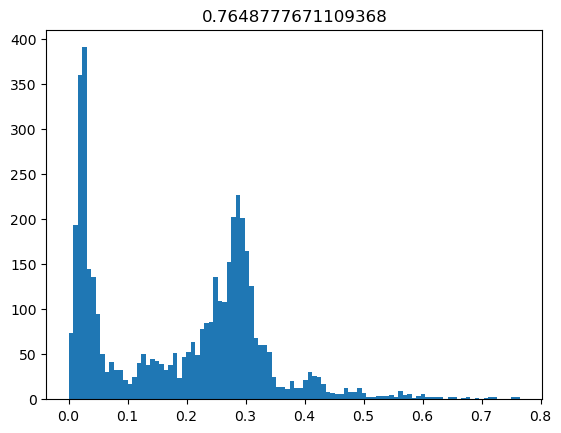

In [14]:
plt.hist(ys, bins=100)
plt.title(f'{np.max(ys)}')

Text(0.5, 1.0, '0.8003690423451221')

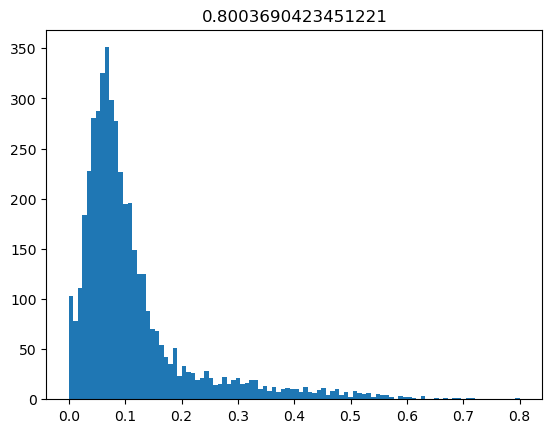

In [15]:
plt.hist(zs, bins=100)
plt.title(f'{np.max(zs)}')

Text(0.5, 1.0, '0.5183257906620967')

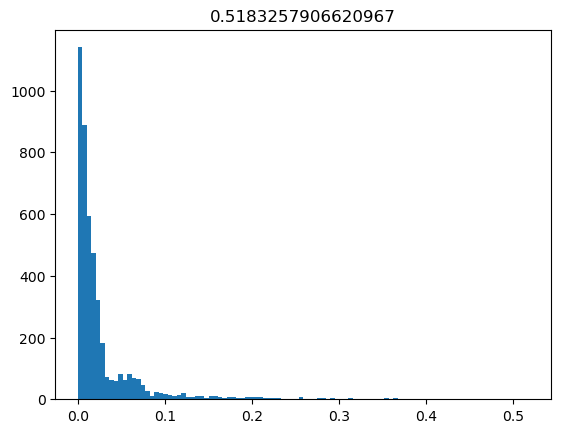

In [16]:
plt.hist(bs, bins=100)
plt.title(f'{np.max(bs)}')